In [116]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb

In [117]:
df = pd.read_csv("../data/creditcard.csv")

# Train test Splitting

In [118]:
X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=69
)


# Scaling Features

In [119]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Finding Normal/Fraud ratio
 handles the Imbalanced Dataset Situation

In [120]:
ratio = int(np.sum(y_train == 0) / np.sum(y_train == 1))
ratio

554

# XGBoost model Training

## Training and Evaluating Base Model with basic parameters. Then fitting Best parameters 

In [121]:
# baseline_params = {
#     'n_estimators': 500,
#     'max_depth': 6,
#     'learning_rate': 0.05,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'scale_pos_weight': ratio,
#     'eval_metric': 'auc',
#     'use_label_encoder': False,
#     'random_state': 42
# }

# pasting the result of exhaustive GridSeachCV
# 'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8

xgb_clf = xgb.XGBClassifier( n_estimators=500,
    max_depth=7,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=ratio,
    eval_metric="auc",
    random_state=69,
    n_jobs=-1)

xgb_clf.fit(X_train_scaled, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [122]:
y_pred = xgb_clf.predict(X_test_scaled)
y_prob = xgb_clf.predict_proba(X_test_scaled)[:,1]


print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))
print("Classification Report:\n",classification_report(y_test, y_pred))
print("ROC-AUC:\n", roc_auc_score(y_test, y_prob))


Confusion Matrix:
 [[56853    27]
 [   11    71]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56880
           1       0.72      0.87      0.79        82

    accuracy                           1.00     56962
   macro avg       0.86      0.93      0.89     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC:
 0.9823051739219923


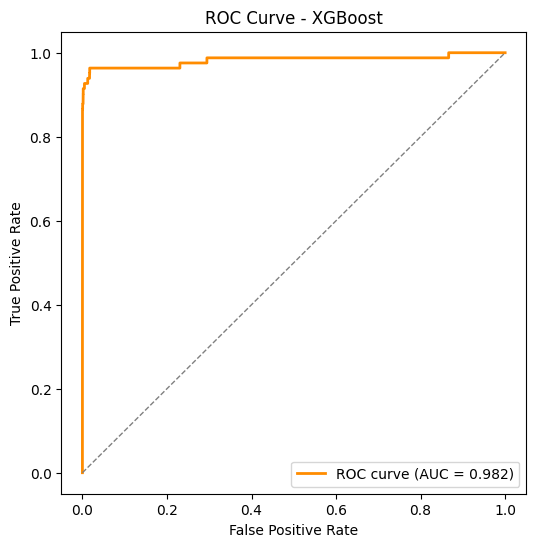

In [123]:
from sklearn.metrics import roc_curve, auc

y_proba = xgb_clf.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend(loc="lower right")
plt.show()


# Cross validation with Exhaustive GridSearchCV

In [124]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     "max_depth": [3, 5, 7],
#     "learning_rate": [0.01, 0.05, 0.1],
#     "n_estimators": [200, 500, 800],
#     "subsample": [0.8, 1.0],
#     "colsample_bytree": [0.8, 1.0]
# }

# grid_search = GridSearchCV(
#     estimator=xgb.XGBClassifier(
#         scale_pos_weight=ratio,
#         eval_metric="auc",
#         use_label_encoder=False,
#         random_state=42
#     ),
#     param_grid=param_grid,
#     scoring="roc_auc",
#     cv=3,
#     verbose=2,
#     n_jobs=-1
# )

# grid_search.fit(X_train_scaled, y_train)

# print("Best parameters:", grid_search.best_params_)
# print("Best ROC-AUC:", grid_search.best_score_)


# Model Evaluation (Baseline VS Tuned)
## Baseline Model

|                   | Predicted Normal | Predicted Fraud |
| ----------------- | ---------------- | --------------- |
| Actual Normal | 56873            | 7               |
| Actual Fraud  | 12               | 70              |

## Tuned Model

|                   | Predicted Normal | Predicted Fraud |
| ----------------- | ---------------- | --------------- |
| Actual Normal | 56853            | 27              |
| Actual Fraud  | 11               | 71              |

## Classification Reports
| Metric       | Baseline (Class 1 = Fraud) | Tuned (Class 1 = Fraud) |
|--------------|-----------------------------|--------------------------|
| **Precision** | 0.91                        | 0.72                     |
| **Recall**    | 0.85                        | 0.87                     |
| **F1-Score**  | 0.88                        | 0.79                     |
| **Accuracy**  | 1.00                        | 1.00                     |
| **ROC-AUC**   | 0.985                       | 0.982                    |


# Saving Models

In [125]:
import joblib

#joblib.dump(xgb_clf,'../models/xgboost_model_tuned.pkl')
# joblib.dump(scaler,'../models/scaler.pkl')